## PyTorch Basics

Author: Tobias Uelwer

### What is PyTorch?
- PyTorch is a Python Deep Learning library
- Allows us to easily train neural networks, i.e. calculate gradients und update weights
- Developed by Facebook's artificial-intelligence research group
- Works hand in hand with NumPy arrays

(See: https://pytorch.org/ and https://en.wikipedia.org/wiki/PyTorch)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

1.0.0


In [2]:
# we create a new PyTorch tensor from a NumPy tensor
torch.from_numpy(np.ones((2,2)))
# we can instantanly access its values unlike we are used to from tensorflow

tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)

In [3]:
# generate a random tensor
A = torch.randn(4,5)
A

tensor([[ 0.8605, -0.0954,  0.8896, -0.8866,  1.4043],
        [ 0.8485,  0.7975, -0.2924,  0.3581,  0.1260],
        [ 0.5983, -1.1450, -0.8016,  0.6016,  0.7178],
        [ 0.6957, -0.4094,  0.2497,  0.5142, -1.7617]])

In [4]:
# indexing
A[0,0]

tensor(0.8605)

In [5]:
# more indexing
A[:,2]

tensor([ 0.8896, -0.2924, -0.8016,  0.2497])

In [6]:
# get the shape of A
A.shape

torch.Size([4, 5])

In [7]:
# traces and matrix transpose
torch.trace(torch.t(A) @ A)

tensor(13.1553)

In [8]:
# the function item() returns a simple Python scalar
torch.sum(A**2).item()

13.15528678894043

In [9]:
# reshaping
A.view(-1,2,10)

tensor([[[ 0.8605, -0.0954,  0.8896, -0.8866,  1.4043,  0.8485,  0.7975,
          -0.2924,  0.3581,  0.1260],
         [ 0.5983, -1.1450, -0.8016,  0.6016,  0.7178,  0.6957, -0.4094,
           0.2497,  0.5142, -1.7617]]])

In [10]:
# flattens a tensor to a vector
Ones = torch.ones((2,1,9, 1))
Ones.shape, Ones.squeeze().shape

(torch.Size([2, 1, 9, 1]), torch.Size([2, 9]))

In [11]:
# add dimensions
torch.ones(9).unsqueeze(0).shape, torch.ones(9).unsqueeze(1).shape

(torch.Size([1, 9]), torch.Size([9, 1]))

In [12]:
# add new dimensions (this also works with numpy arrays...)
A[None, :, None,:, None].shape

torch.Size([1, 4, 1, 5, 1])

In [13]:
# elementwise power
torch.pow(A,2)

tensor([[0.7405, 0.0091, 0.7913, 0.7860, 1.9720],
        [0.7199, 0.6360, 0.0855, 0.1283, 0.0159],
        [0.3580, 1.3111, 0.6426, 0.3619, 0.5152],
        [0.4840, 0.1676, 0.0623, 0.2644, 3.1037]])

In [14]:
# logarithm and absolute value
torch.log(torch.abs(A))

tensor([[-0.1502, -2.3494, -0.1170, -0.1204,  0.3395],
        [-0.1643, -0.2263, -1.2295, -1.0269, -2.0714],
        [-0.5136,  0.1354, -0.2211, -0.5082, -0.3316],
        [-0.3628, -0.8930, -1.3877, -0.6652,  0.5663]])

In [15]:
# all close
torch.allclose(torch.log(torch.exp(A)), A)

True

### Automatic differentiation

In [16]:
# if we want to calculate gradients we need to specify this
# by setting requires_grad=True for each tensor
X = torch.ones(2, 2, requires_grad=True)
X

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [17]:
# we build a simple computational graph 
y = torch.sum(torch.exp(X))
y

tensor(10.8731, grad_fn=<SumBackward0>)

In [18]:
# In pytorch gradients are accumulated each time backward() is called.
# Keep that in mind!
y.backward(retain_graph=True) # don't free the graph buffers after backprop
X.grad

tensor([[2.7183, 2.7183],
        [2.7183, 2.7183]])

In [19]:
# to suppress this behavior we have to reset the gradients by
X.grad.zero_()
y.backward(retain_graph=True) # dont free the graph buffers after backprop
X.grad

tensor([[2.7183, 2.7183],
        [2.7183, 2.7183]])

### Optimizing functions

In [20]:
# define variable
x = torch.tensor([2.,2.], requires_grad=True).float()

We want to minimize the function $f(x_1, x_2) = 100(x_2-x_1)^2 + (1-x_1)^2$.

The function has a minimum at $(1,1)$.

In [21]:
# define objective
f = lambda x: 100*(x[1]-x[0]**2)**2+(1-x[0])**2

In [22]:
# instantiate optimizer
opt = torch.optim.SGD([x], lr=0.0005)

In [23]:
i = 0
while True:
    opt.zero_grad()
    f_val = f(x)
    f_val.backward()
    opt.step()
    i += 1
    if torch.norm(x.grad)<0.001:
        print("Converged after {} iterations.".format(i))
        print("Minimum: {}".format(str(x.detach().numpy())))
        break
    if i>100000:
        print("Maximum number of iterations reached.")
        break

Converged after 33995 iterations.
Minimum: [1.0011183 1.0022423]


## Implementing a linear regression model from scratch

In [24]:
# let's implement a simple linear regression model from scratch
w = torch.randn(2, requires_grad=True)

# generate some data
x = torch.rand(100)
y = x*2 + torch.randn(100)*0.04

# define a simple linear model
def pred(x,w):
    return torch.t(torch.stack([torch.ones(100),x], dim=0))@w

# define mean squared error function
def l2(y,y_pred):
    return (y_pred-y).pow(2).sum()*(1/len(y_pred))

# loss history
h = []

# apply gradient descent updates to w
lr = 0.1
for k in range(500):
    
    y_pred =  pred(x,w)
    loss = l2(y_pred, y)
    loss.backward()
    h += [loss.item()]
    if k % 50 == 0:
        print(h[-1])
        
    w.data = w.data -(lr*w.grad)
    w.grad.zero_()    

0.412748247385025
0.0025663592386990786
0.0019450848922133446
0.0018027048790827394
0.0017700761090964079
0.0017625992186367512
0.0017608857015147805
0.001760492566972971
0.0017604026943445206
0.0017603819724172354


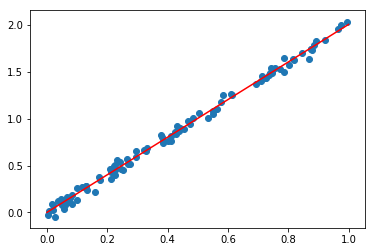

In [25]:
x_plot = torch.linspace(0,1)
plt.scatter(x,y)
plt.plot(x_plot.numpy(), pred(x_plot,w).detach().numpy(), 'r')

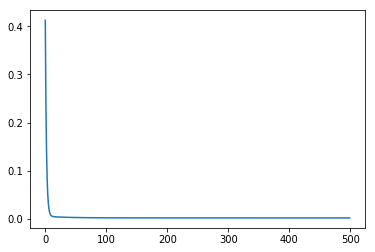

In [26]:
plt.plot(h)

## Implementing a linear regression model - simpler way

In [27]:
# generate some data
x = torch.rand(100)
y = x*2 + torch.randn(100)*0.04

In [28]:
x = x.unsqueeze(1)
y = y.unsqueeze(1)

In [29]:
from torch import nn
from torch import optim

In [30]:
model = nn.Linear(in_features=1, out_features=1) # define model

criterion = nn.MSELoss() # instantiate loss 

optimizer = optim.SGD(model.parameters(), lr=0.1) # instantiate optimizer

In [31]:
for k in range(0, 500):
    # set the parameter gradients to zero
    optimizer.zero_grad()

    # forward pass
    outputs = model(x)
        
    # training loss
    loss = criterion(outputs, y)
    
    if k % 50 == 0:
        print(loss.item())
        
    # backward pass
    loss.backward()
    optimizer.step()

3.0019092559814453
0.10292942076921463
0.024384859949350357
0.00651630200445652
0.00245128502137959
0.0015265073161572218
0.0013161251554265618
0.0012682635569944978
0.0012573759304359555
0.0012548982631415129


In [32]:
list(model.parameters())

[Parameter containing:
 tensor([[1.9914]], requires_grad=True), Parameter containing:
 tensor([0.0100], requires_grad=True)]